In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

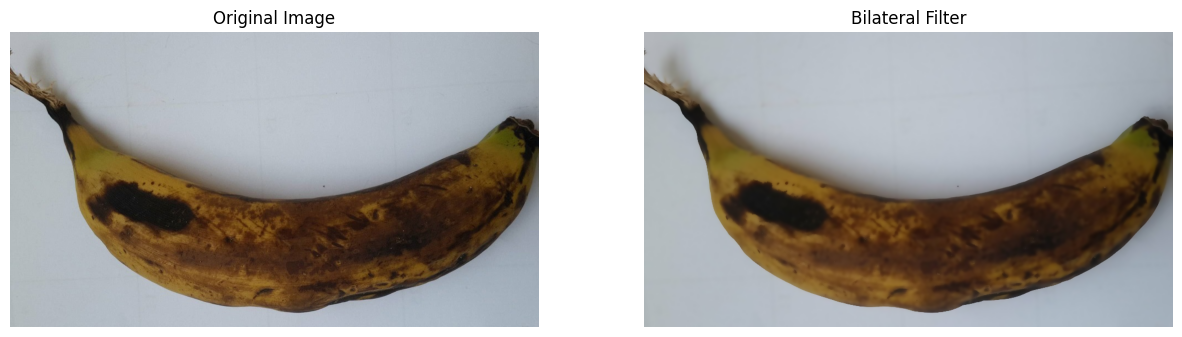

In [2]:
import cv2
import matplotlib.pyplot as plt

# apply bilateral filter to an image
def bilateral_filter(img, d, sigmaColor, sigmaSpace):
    return cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)

# apply median filter to an image
def median_filter(img, ksize):
    return cv2.medianBlur(img, ksize)

# apply gaussian filter to an image
def gaussian_filter(img, ksize, sigmaX):
    return cv2.GaussianBlur(img, ksize, sigmaX)

# apply average filter to an image
def average_filter(img, ksize):
    return cv2.blur(img, ksize)

# apply sobel filter to an image
def sobel_filter(img, dx, dy, ksize):
    return cv2.Sobel(img, cv2.CV_64F, dx, dy, ksize)

img = cv2.imread('data/Overripen/v001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# apply bilateral filter
img_bilateral = bilateral_filter(img, 9, 75, 75)

# visualize the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_bilateral)
plt.title('Bilateral Filter')
plt.axis('off')

plt.show()

In [13]:
import os
from PIL import Image
from torchvision import transforms
import glob

# Define augmentations (same as before)
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(10,90)),
    # transforms.RandomResizedCrop(scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Reduced color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
])

# Specify source and destination directories
source_dir = 'data/Yellowish_Green'  # Replace with your path
output_dir = 'augmented_dataset/Yellowish_Green'  # Replace with your output path

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load images and apply augmentations
for img_path in glob.glob(os.path.join(source_dir, '*.jpg')):  # Replace '*.jpg' with appropriate extension
    img = Image.open(img_path)
    for i in range(5):  # Number of augmented images to create per original
        augmented_img = augmentations(img)
        augmented_img.save(os.path.join(output_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{i}.jpg"))


In [20]:
labels_ripeness = ['Green','Midripen','Overripen','Yellowish_Green']

In [4]:
import os
import PIL 

class BananaRipenessDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(label)

        # load augmented images
        for label, class_name in enumerate(os.listdir('augmented_dataset')):
            class_dir = os.path.join('augmented_dataset', class_name)
            for image_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = PIL.Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label
    
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset
dataset = BananaRipenessDataset('data', transform=transform)
            

In [13]:
from torch.utils.data import DataLoader, random_split

# Define dataset sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:
# Useful Modules
import torch
from torch import nn
from math import ceil

In [6]:
''' A simple Convolution, Batch Normalization, and Activation Class'''

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
#------------------------------------------------------------------------------

''' Squeeze and Excitation Block '''

class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        
        y = self.se(x)
        
        return x * y
                                    
#------------------------------------------------------------------------------

''' Stochastic Depth Module'''

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
        
#-------------------------------------------------------------------------------

''' Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
    with Squeeze and Excitation Block and Stochastic Depth. 
'''

class MBConvN(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x
    

#----------------------------------------------------------------------------------------------

'''Efficient-net Class'''

class EfficientNet(nn.Module):
    
    '''Generic Efficient net class which takes width multiplier, Depth multiplier, and Survival Prob.'''
    
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [7]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

In [8]:
def test():
    version = 'b0'
    width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
    net = EfficientNet(width_mult, depth_mult, dropout_rate)
    x = torch.rand(1, 3, res, res)
    y = net(x)
    print(y.size())
    
test()

torch.Size([1, 1000])


In [35]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
#------------------------------------------------------------------------------------------
    
#-----------------------------------------------------------------------------------------

# Model Performance on test data
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
     # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

#------------------------------------------------------------------------------------------------
import copy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #track_training_loss = []
    #track_val_loss = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in train_loader:

            # Load data to device.
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            # Loss and Backpropagation.
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(train_dataset)
        epoch_accuracy = running_accuracy/len(train_dataset)
        #track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, val_loader, len(val_dataset), criterion)

        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model

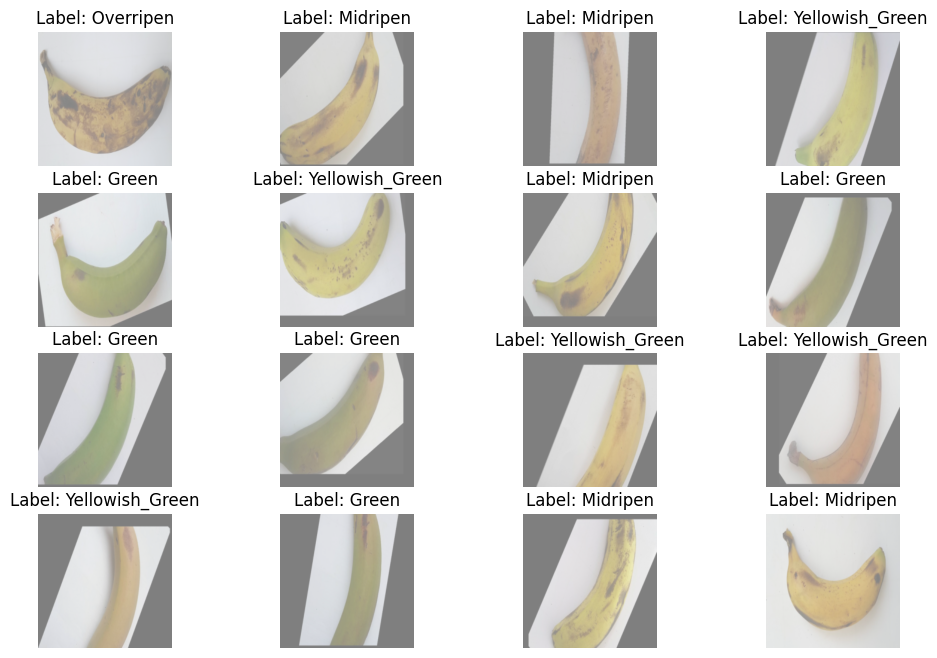

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert the tensor to a numpy array
    img = img / 2 + 0.5  # Unnormalize (if needed)
    npimg = img.numpy()  # Convert to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H, W, C)
    plt.axis('off')

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Create a grid of images
plt.figure(figsize=(12, 8))
for i in range(16):  # Display first 16 images
    plt.subplot(4, 4, i + 1)  # 4 rows, 4 columns
    imshow(images[i])  # Show the image
    plt.title(f'Label: {labels_ripeness[labels[i]]}')  # Show the label
plt.show()



In [ ]:
# Pytorch Standard Resnet-18 Model.
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

# Initialize Efficientnet model
NUM_OF_CLASSES = len(labels_ripeness)
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device.


# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

NUM_OF_EPOCHS = 15

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/15
------------------------------
Training Loss: 1.3992 Training Acc.: 0.2667
Found better model...
Updating the model weights....

Val Loss: 1.3857 Val Acc.: 0.2143


Epoch 2/15
------------------------------
Training Loss: 1.3830 Training Acc.: 0.3055

Epoch 3/15
------------------------------
Training Loss: 1.3525 Training Acc.: 0.3420
Found better model...
Updating the model weights....

Val Loss: 1.3769 Val Acc.: 0.2527


Epoch 4/15
------------------------------
Training Loss: 1.3026 Training Acc.: 0.3878
Found better model...
Updating the model weights....

Val Loss: 1.2921 Val Acc.: 0.3462


Epoch 5/15
------------------------------


In [24]:
# test the model
test_loss, test_accuracy = calculate_loss_and_accuracy(best_model, test_loader, len(test_dataset), criterion)

print(f'Test Loss: {test_loss:.4f} Test Acc.: {test_accuracy:.4f}')


Test Loss: 1.2877 Test Acc.: 0.4044


tensor([0], device='cuda:0')


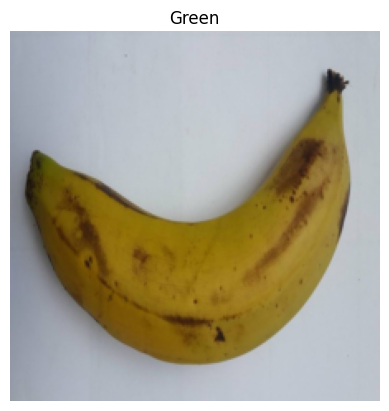

In [34]:
# load images and predict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the image
img = Image.open('data/Midripen/m001.jpg')
img = transform(img).unsqueeze(0).to(device)

# Predict the class
best_model.eval()
with torch.no_grad():
    output = best_model(img)
    _, pred = torch.max(output, 1)
    print(pred)

# Display the image and the prediction
plt.imshow(np.array(img.squeeze().permute(1, 2, 0).cpu()))
plt.title(labels_ripeness[pred.item()])
plt.axis('off')
plt.show()